<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
! pip install transforms3d

     |████████████████████████████████| 62 kB 1.0 MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59373 sha256=9fbf5b0cc66a54d2490f5b195b36b91e0aebe09ea714e1652ca3729f527083a9
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d


In [ ]:
import numpy as np

def rot2eul(R):
    beta = -np.arcsin(R[2,0])
    alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
    gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
    return np.array((alpha, beta, gamma))

def eul2rot(theta) :

    R = np.array([[np.cos(theta[1])*np.cos(theta[2]),       np.sin(theta[0])*np.sin(theta[1])*np.cos(theta[2]) - np.sin(theta[2])*np.cos(theta[0]),      np.sin(theta[1])*np.cos(theta[0])*np.cos(theta[2]) + np.sin(theta[0])*np.sin(theta[2])],
                  [np.sin(theta[2])*np.cos(theta[1]),       np.sin(theta[0])*np.sin(theta[1])*np.sin(theta[2]) + np.cos(theta[0])*np.cos(theta[2]),      np.sin(theta[1])*np.sin(theta[2])*np.cos(theta[0]) - np.sin(theta[0])*np.cos(theta[2])],
                  [-np.sin(theta[1]),                        np.sin(theta[0])*np.cos(theta[1]),                                                           np.cos(theta[0])*np.cos(theta[1])]])

    return R


R = np.array([[ 0.9982552 , -0.03323557, -0.04880523],
       [-0.03675031,  0.29723396, -0.95409716],
       [-0.04621654, -0.95422606, -0.29549393]])

ang = rot2eul(R)
eul2rot(ang)

import transforms3d.euler as eul
ang = eul.mat2euler(R, axes='sxyz')
eul.euler2mat(ang[0], ang[1], ang[2], axes='sxyz')

array([[ 0.9982552 , -0.05500105,  0.02148111],
       [-0.03675031, -0.29398557,  0.95510308],
       [-0.04621654, -0.95422606, -0.29549393]])

In [ ]:
a = dataset.X

In [ ]:
c = Tools.YXZ_to_XYZ(a)

In [ ]:
c[0,0,0]

array([-52.222594, 178.085973,  -0.284332])

In [ ]:
rot = eul2rot(c)

In [ ]:
eul = rot2eul(rot)

In [ ]:
eul

array([[[[ 1.18448111, -0.98480825, -0.284332  ],
         [ 0.45303677,  1.27160735, -1.26502965],
         [ 0.98340335,  0.561654  ,  0.300012  ],
         ...,
         [ 0.98373297, -0.14129119, -0.24713884],
         [-0.89698804,  0.571895  , -0.97979269],
         [ 0.966929  ,  0.442967  ,  0.188843  ]],

        [[ 1.15543511, -1.02060325, -0.274728  ],
         [ 0.46498477,  1.22843635, -1.26249665],
         [ 0.98602135,  0.554335  ,  0.302539  ],
         ...,
         [ 0.97272997, -0.10771819, -0.20976184],
         [-0.89543704,  0.595398  , -0.98167169],
         [ 0.968918  ,  0.422678  ,  0.179095  ]],

        [[ 1.12229611, -1.05217825, -0.265528  ],
         [ 0.48781677,  1.21758935, -1.25350865],
         [ 0.97570635,  0.510396  ,  0.30911   ],
         ...,
         [ 0.96354397, -0.07742219, -0.17874084],
         [-0.89302904,  0.61344   , -0.98646369],
         [ 0.969199  ,  0.408198  ,  0.173493  ]],

        ...,

        [[ 1.44143311,  0.8347174 , -0

In [ ]:
rot

array([[-0.5308186 , -0.84647018, -0.04147106],
       [ 0.15513195, -0.14515721,  0.97717115],
       [-0.83316607,  0.51226713,  0.20836672]])

In [ ]:
import copy
class Tools(object):
  @staticmethod
  def YXZ_to_ZYX(matrix):
    batch = matrix.shape[0]
    frames = matrix.shape[1]
    joints = int(matrix.shape[2] / 3)
    b = copy.deepcopy(matrix.reshape(batch, frames, joints,3))
    Y = b[:, :, :, 0]
    X = b[:, :, :, 1]
    Z = b[:, :, :, 2]
    c = copy.deepcopy(b)
    c[:, :, :, 0] = Z
    c[:, :, :, 1] = Y
    c[:, :, :, 2] = X
    return c

  @staticmethod
  def ZYX_to_YXZ(matrix):
    batch = matrix.shape[0]
    frames = matrix.shape[1]
    joints = matrix.shape[2]
    b = copy.deepcopy(matrix.reshape(batch, frames, joints,3))
    Z = b[:, :, :, 0]
    Y = b[:, :, :, 1]
    X = b[:, :, :, 2]
    c = copy.deepcopy(b)
    c[:, :, :, 0] = Y
    c[:, :, :, 1] = X
    c[:, :, :, 2] = Z
    return c.reshape((batch, frames, joints*3))

  def YXZ_to_XYZ(matrix):
    batch = matrix.shape[0]
    frames = matrix.shape[1]
    joints = int(matrix.shape[2] / 3)
    b = copy.deepcopy(matrix.reshape(batch, frames, joints,3))
    Y = b[:, :, :, 0]
    X = b[:, :, :, 1]
    Z = b[:, :, :, 2]
    c = copy.deepcopy(b)
    c[:, :, :, 0] = X
    c[:, :, :, 1] = Y
    c[:, :, :, 2] = Z
    return c

  @staticmethod
  def XYZ_to_YXZ(matrix):
    batch = matrix.shape[0]
    frames = matrix.shape[1]
    joints = matrix.shape[2]
    b = copy.deepcopy(matrix.reshape(batch, frames, joints,3))
    X = b[:, :, :, 0]
    Y = b[:, :, :, 1]
    Z = b[:, :, :, 2]
    c = copy.deepcopy(b)
    c[:, :, :, 0] = Y
    c[:, :, :, 1] = X
    c[:, :, :, 2] = Z
    return c.reshape((batch, frames, joints*3))

  # Adapted from https://github.com/papagina/RotationContinuity/blob/master/shapenet/code/tools.py.
  # euler => tf.Tensor(batch, joints * 3) (-1, 69)
  # batch => batch_size
  # joints => no. of joints
  # rotation_matrices => tf.Tensor(batch, joints, 3, 3)
  def ZYX_euler_to_rotation_matrices(euler):
    batch = euler.shape[0]
    frames = euler.shape[1]
    joints = euler.shape[2]
    b = np.deg2rad(euler % 360)  
    cz = np.cos(b[:, :, :, 0]).reshape(batch, frames, joints, 1, 1)
    sz = np.sin(b[:, :, :, 0]).reshape(batch, frames, joints, 1, 1)
    cy = np.cos(b[:, :, :, 1]).reshape(batch, frames, joints, 1, 1)
    sy = np.sin(b[:, :, :, 1]).reshape(batch, frames, joints, 1, 1)
    cx = np.cos(b[:, :, :, 2]).reshape(batch, frames, joints, 1, 1)
    sx = np.sin(b[:, :, :, 2]).reshape(batch, frames, joints, 1, 1)    
    row1=np.concatenate((cz*cy,  cz*sy*sx-sz*cx,    cz*sy*cx+sz*sx), 4)
    row2=np.concatenate((sz*cy, sz*sy*sx+cz*cx,  sz*sy*cx-cz*sx), 4)
    row3=np.concatenate((-sy, cy*sx,  cy*cx), 4)
    matrix = np.concatenate((row1, row2, row3), 3)         
    # matrix[np.abs(matrix) < 1e-6] = 0
    return matrix  

  @staticmethod
  # Adapted from https://github.com/papagina/RotationContinuity/blob/master/shapenet/code/tools.py.
  # 
  # euler => tf.Tensor(batch, joints * 3) (-1, 69)
  # batch => batch_size
  # joints => no. of joints
  # rotation_matrices => tf.Tensor(batch, frames, joints, 3, 3)
  def rotation_matrices_to_ZYX_euler(rotm):
    eul = np.zeros((rotm.shape))
    if (rotm[:,:,:,2,0] < 1):
      if (rotm[2,0] > -1):                                   # case 1: if r31 ~= ±1
          # Solution with positive sign. It limits the range of the values of theta_y to (-pi/2, pi/2):
          eul[:,:,:,0,0] = np.arctan2(rotm[:,:,:,1,0], rotm[:,:,:,0,0])          # theta_z
          eul[:,:,:,1,0] = np.arcsin(-rotm[:,:,:,2,0])                     # theta_y
          eul[:,:,:,2,0] = np.arctan2(rotm[:,:,:,2,1], rotm[:,:,:,2,2])          # theta_x
      else:                                                # case 2: if r31 = -1
          # theta_x and theta_z are linked --> Gimbal lock:
          # There are infinity number of solutions for theta_x - theta_z = atan2(-r23, r22).
          # To find a solution, set theta_x = 0 by convention.
          eul[:,:,:,0,0] = -np.arctan2(-rotm[:,:,:,1,2], rotm[:,:,:,1,1])
          eul[:,:,:,1,0] = math.pi/2
          eul[:,:,:,2,0] = 0
    else:                                                   # case 3: if r31 = 1
      # Gimbal lock: There is not a unique solution for
      #   theta_x + theta_z = atan2(-r23, r22), by convention, set theta_x = 0.
      eul[:,:,:,0,0] = np.arctan2(-rotm[:,:,:,1,2], rotm[:,:,:,1,1])
      eul[:,:,:,1,0] = -math.pi/2
      eul[:,:,:,2,0] = 0
    return np.rad2deg(eul)

In [ ]:
import transforms3d.euler as eul
rot = eul.euler2mat(c[0], c[1], c[2], axes='szyx')
eul = eul.mat2euler(rot)

In [ ]:
rot

array([[-0.55033279,  0.82878273, -0.10125713],
       [ 0.0544805 , -0.08537114, -0.99485861],
       [-0.83316607, -0.55301985,  0.00183004]])

In [ ]:
c

array([359.715668, 178.085973, 307.777406])

In [ ]:
'''
Copyright (c) 2019 [Jia-Yau Shiau]
Code work by Jia-Yau (jiayau.shiau@gmail.com).
--------------------------------------------------
The implementation of 6D rotatiton representation,
based on 

    https://arxiv.org/abs/1812.07035

"On the continuity of rotation representations in neural networks"
Yi Zhou, Connelly Barnes, Jingwan Lu, Jimei Yang, Hao Li.
Conference on Neural Information Processing Systems (NeurIPS) 2019.
'''
import tensorflow as tf


def tf_rotation6d_to_matrix(r6d):
    """ Compute rotation matrix from 6D rotation representation.
        Implementation base on 
            https://arxiv.org/abs/1812.07035
        [Inputs]
            6D rotation representation (last dimension is 6)
        [Returns]
            flattened rotation matrix (last dimension is 9)
    """
    tensor_shape = r6d.get_shape().as_list()

    if not tensor_shape[-1] == 6:
        raise AttributeError("The last demension of the inputs in tf_rotation6d_to_matrix should be 6, \
            but found tensor with shape {}".format(tensor_shape[-1]))

    r6d   = tf.reshape(r6d, [-1,6])
    x_raw = r6d[:,0:3]
    y_raw = r6d[:,3:6]

    x = tf.nn.l2_normalize(x_raw, axis=-1)
    z = tf.linalg.cross(x, y_raw)
    z = tf.nn.l2_normalize(z, axis=-1)
    y = tf.linalg.cross(z, x)

    x = tf.reshape(x, [-1,3,1])
    y = tf.reshape(y, [-1,3,1])
    z = tf.reshape(z, [-1,3,1])
    matrix = tf.concat([x,y,z], axis=-1)

    if len(tensor_shape) == 1:
        matrix = tf.reshape(matrix, [9])
    else:
        output_shape = tensor_shape[:-1] + [9]
        matrix = tf.reshape(matrix, output_shape)

    return matrix

def tf_matrix_to_rotation6d(mat):
    """ Get 6D rotation representation for rotation matrix.
        Implementation base on 
            https://arxiv.org/abs/1812.07035
        [Inputs]
            flattened rotation matrix (last dimension is 9)
        [Returns]
            6D rotation representation (last dimension is 6)
    """
    tensor_shape = mat.get_shape().as_list()

    if not ((tensor_shape[-1] == 3 and tensor_shape[-2] == 3) or (tensor_shape[-1] == 9)):
        raise AttributeError("The inputs in tf_matrix_to_rotation6d should be [...,9] or [...,3,3], \
            but found tensor with shape {}".format(tensor_shape[-1]))

    mat = tf.reshape(mat, [-1, 3, 3])
    r6d = tf.concat([mat[...,0], mat[...,1]], axis=-1)

    if len(tensor_shape) == 1:
        r6d = tf.reshape(r6d, [6])

    return r6d

In [ ]:
import math
from functools import reduce

import numpy as np
import tensorflow as tf
from termcolor import colored
def euler2mat(z=0, y=0, x=0):
    ''' Return matrix for rotations around z, y and x axes

    Uses the z, then y, then x convention above

    Parameters
    ----------
    z : scalar
       Rotation angle in radians around z-axis (performed first)
    y : scalar
       Rotation angle in radians around y-axis
    x : scalar
       Rotation angle in radians around x-axis (performed last)

    Returns
    -------
    M : array shape (3,3)
       Rotation matrix giving same rotation as for given angles

    Code fork from "https://afni.nimh.nih.gov/pub/dist/src/pkundu/meica.libs/nibabel/eulerangles.py".
    '''
    Ms = []
    if z:
        cosz = math.cos(z)
        sinz = math.sin(z)
        Ms.append(np.array(
                [[cosz, -sinz, 0],
                 [sinz, cosz, 0],
                 [0, 0, 1]]))
    if y:
        cosy = math.cos(y)
        siny = math.sin(y)
        Ms.append(np.array(
                [[cosy, 0, siny],
                 [0, 1, 0],
                 [-siny, 0, cosy]]))
    if x:
        cosx = math.cos(x)
        sinx = math.sin(x)
        Ms.append(np.array(
                [[1, 0, 0],
                 [0, cosx, -sinx],
                 [0, sinx, cosx]]))
    if Ms:
        return reduce(np.dot, Ms[::-1])
    return np.eye(3)

In [ ]:
np_mat = []
for i in range(3):
    np_mat.append(euler2mat(i, i, i))

np_mat = np.array(np_mat)

tf_mat = tf.convert_to_tensor(np_mat)
tf_r6d = tf_matrix_to_rotation6d(tf_mat)
tf_mat_from_r6d = tf_rotation6d_to_matrix(tf_r6d)
eul_from_mat = euler_angles_from_rotation_matrices(tf_mat_from_r6d)

print (colored("[Original Rotation Matrix]", 'yellow'))
print (tf_mat)
print (colored("[Rotation 6D from Rotation Matrix]", 'yellow'))
print (tf_r6d)
print (colored("[Rotation Matrix from Rotation 6d]", 'yellow'))
print (tf.reshape(tf_mat_from_r6d, (-1,3,3)))
print (colored("eul_from_mat", 'yellow'))
print (eul_from_mat)

[Original Rotation Matrix]
tf.Tensor(
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.29192658 -0.45464871  0.84147098]
  [ 0.83722241 -0.30389665 -0.45464871]
  [ 0.46242567  0.83722241  0.29192658]]

 [[ 0.17317819  0.37840125  0.90929743]
  [-0.72248053 -0.57864876  0.37840125]
  [ 0.66935133 -0.72248053  0.17317819]]], shape=(3, 3, 3), dtype=float64)
[Rotation 6D from Rotation Matrix]
tf.Tensor(
[[ 1.          0.          0.          0.          1.          0.        ]
 [ 0.29192658  0.83722241  0.46242567 -0.45464871 -0.30389665  0.83722241]
 [ 0.17317819 -0.72248053  0.66935133  0.37840125 -0.57864876 -0.72248053]], shape=(3, 6), dtype=float64)
[Rotation Matrix from Rotation 6d]
tf.Tensor(
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.29192658 -0.45464871  0.84147098]
  [ 0.83722241 -0.30389665 -0.45464871]
  [ 0.4624256

In [ ]:
def compute_euler_angles_from_rotation_matrices(rotation_matrices):
    batch=rotation_matrices.shape[0]
    frames = rotation_matrices.shape[1] 
    joint = rotation_matrices.shape[2]
    R=copy.deepcopy(rotation_matrices)
    sy = np.sqrt(R[:,:,:,0,0]*R[:,:,:,0,0]+R[:,:,:,1,0]*R[:,:,:,1,0])
    singular= sy<1e-6
        
    x=np.arctan2(R[:,:,:,2,1], R[:,:,:,2,2])
    y=np.arctan2(-R[:,:,:,2,0], sy)
    z=np.arctan2(R[:,:,:,1,0],R[:,:,:,0,0])
    
    xs=np.arctan2(-R[:,:,:,1,2], R[:,:,:,1,1])
    ys=np.arctan2(-R[:,:,:,2,0], sy)
    zs=R[:,:,:,1,0]*0
        
    out_euler=np.zeros((batch, frames, joint, 3))
    out_euler[:,:,:,2]=x*(1-singular)+xs*singular
    out_euler[:,:,:,1]=y*(1-singular)+ys*singular
    out_euler[:,:,:,0]=z*(1-singular)+zs*singular
        
    big = out_euler > 180

    out_euler=np.zeros((batch, frames, joint, 3))
    out_euler[:,:,:,2]=x*(1-singular)+xs*singular
    out_euler[:,:,:,1]=y*(1-singular)+ys*singular
    out_euler[:,:,:,0]=z*(1-singular)+zs*singular

    return np.rad2deg(out_euler)

In [ ]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('yxz', x[0][0], degrees=True)

In [4]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'try euler angles -> rotation matrix -> 6d representation'

[main 31ccee3] try euler angles -> rotation matrix -> 6d representation
 2 files changed, 42 insertions(+), 1 deletion(-)
 rewrite setup.ipynb (94%)


In [ ]:
! git add .

In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 126.83 KiB | 7.93 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   bd21b85..c461aaf  main -> main


In [5]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
%cd /content/drive/MyDrive/CS490/models
! mkdir models_smoothened_data

/content/drive/MyDrive/CS490/models
mkdir: cannot create directory ‘models_smoothened_data’: File exists


In [7]:
np.ceil(1.6)

2.0

In [ ]:
# path is the path to the dataset
# dataset2 = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=400)
dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=200)

anger


100%|██████████| 65/65 [00:11<00:00,  5.57it/s]


In [ ]:
Dataset.balance(dataset2)

No. of samples in each class will be:  640


In [ ]:
y = dataset.smoothen(x.reshape(1,200,69))

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/one_class_2022.02.27-15:51:28

In [ ]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset2.frames, dataset2.n_features),  # because sin and cos values for each value
        'n_classes' : dataset2.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 1,
        'dataset_balanced' : True,
        'critic_batch_norm' : False,
        'critic_instance_norm' : False,
        'critic_layer_norm' : True,
        'critic_weight_norm' : False,
        'critic_cond_layer_norm' : False,
        'generator_batch_norm' : False,
        'generator_layer_norm' : False,
        'generator_layer_norm_plus' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0,      # for the gradient penalty used in critic
        'smoothen' : False,
        'note' : 'only critic'
      }

In [ ]:
! mkdir /content/drive/MyDrive/CS490/models/only_critic_projection_test

In [ ]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

In [ ]:
generator = define_norm_generator(config)

In [ ]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset2, outputs_path, 'only_critic_projection_wrong', critic, generator)

In [ ]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [ ]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/one_class_2022.02.28-13:42:08/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

In [ ]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

>1, 1/30, c_loss=4.392, g_loss=0.000
>1, 2/30, c_loss=3.770, g_loss=0.000
>1, 3/30, c_loss=3.319, g_loss=0.000
>1, 4/30, c_loss=2.480, g_loss=0.000
>1, 5/30, c_loss=1.850, g_loss=0.000
>1, 6/30, c_loss=1.257, g_loss=0.000
>1, 7/30, c_loss=1.034, g_loss=0.000
>1, 8/30, c_loss=0.679, g_loss=0.000
>1, 9/30, c_loss=0.459, g_loss=0.000
>1, 10/30, c_loss=0.230, g_loss=0.000
>1, 11/30, c_loss=0.186, g_loss=0.000
>1, 12/30, c_loss=0.164, g_loss=0.000
>1, 13/30, c_loss=0.175, g_loss=0.000
>1, 14/30, c_loss=0.097, g_loss=0.000
>1, 15/30, c_loss=0.107, g_loss=0.000
>1, 16/30, c_loss=0.138, g_loss=0.000
>1, 17/30, c_loss=0.100, g_loss=0.000
>1, 18/30, c_loss=0.119, g_loss=0.000
>1, 19/30, c_loss=0.061, g_loss=0.000
>1, 20/30, c_loss=0.109, g_loss=0.000
>1, 21/30, c_loss=0.065, g_loss=0.000
>1, 22/30, c_loss=0.057, g_loss=0.000
>1, 23/30, c_loss=0.059, g_loss=0.000
>1, 24/30, c_loss=0.052, g_loss=0.000
>1, 25/30, c_loss=0.039, g_loss=0.000
>1, 26/30, c_loss=0.048, g_loss=0.000
>1, 27/30, c_loss=0.0

KeyboardInterrupt: ignored

In [ ]:
import json
with open('/content/drive/MyDrive/CS490/models/only_critic_projection_wrong2022.04.14-20:38:27/epoch_4/cm.txt', 'r') as file:
  cm = json.load(file)

In [ ]:
np.array(cm) / 10

array([[0.2, 0.1, 0. , 0.1, 0. , 0.1],
       [0.1, 0.3, 0.1, 0. , 0.1, 0.1],
       [0.2, 0. , 0.4, 0. , 0. , 0. ],
       [0.1, 0. , 0.1, 0.5, 0. , 0.2],
       [0. , 0.5, 0.2, 0.1, 0.5, 0. ],
       [0.4, 0.1, 0.2, 0.3, 0.4, 0.6]])

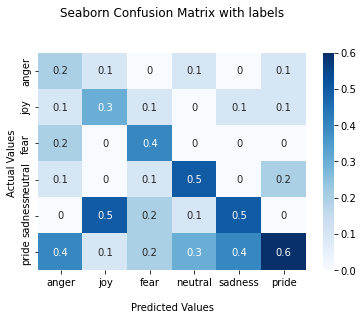

In [ ]:
import seaborn as sns

ax = sns.heatmap(np.array(cm) / 10, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["anger", "joy", "fear", "neutral", "sadness", "pride"])
ax.yaxis.set_ticklabels(["anger", "joy", "fear", "neutral", "sadness", "pride"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/only_critic_projection_wrong2022.04.14-20:33:46

In [ ]:
labels = np.array([0])
labels = np.repeat(labels, 1)
outputs = gan.generate(labels)

In [ ]:
x = outputs * 180

In [ ]:
outputs

array([[[ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        ...,
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ]]], dtype=float32)

In [ ]:
x[0][-1].min()

-184.65588

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/WGAN2022.02.26-15:19:21

In [ ]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models/models_smoothened_data'):
  # if dir[0:10] == 'WGAN_layer' and dir != 'WGAN2022.01.26-14:29:43':
  path = os.path.join('/content/drive/MyDrive/CS490/models/models_smoothened_data', dir)
  ! rm -rf $path

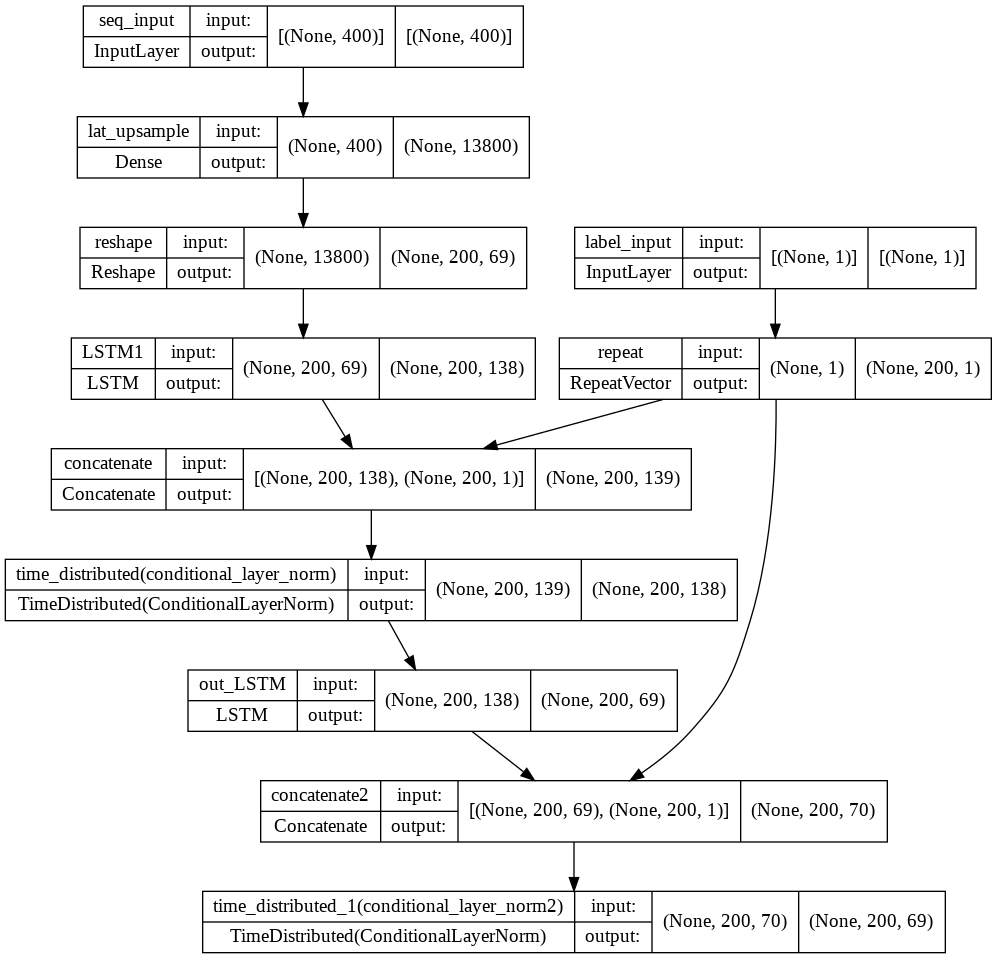

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 200, 138)     0           ['lat_upsample[0][0]']           
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:48:19/epoch_1', 'train_metrics.txt')) as file:
  tm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]

<function matplotlib.pyplot.figure>

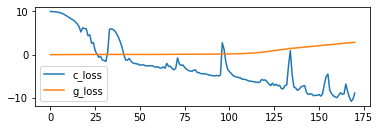

In [ ]:
Base_WGAN.plot_history(gan.train_metrics)

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'cm.txt')) as file:
  cm = json.load(file)